In [1]:

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

engine = create_engine("postgresql://postgres@localhost/hawaii")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [3]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

## Precipitation

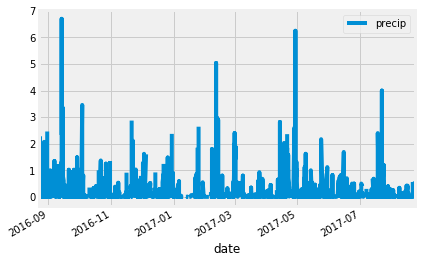

In [6]:
# query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).\
    order_by(desc(Measurement.date)).limit(10).all()[0][0]

end_date = last_date
begin_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores

results = session.query(Measurement.date, Measurement.precip).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.date >= begin_date)

yearly = pd.DataFrame(results).\
    astype({'date': 'datetime64', 'precip': 'float'})

yearly.plot(x='date', y='precip')

In [7]:
# calcualte the summary statistics for the precipitation data
yearly.describe()

,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station

In [8]:
# query to show how many stations are available in this dataset?
results = session.query(func.count(Station.station)).all()
results

[(9)]

In [9]:
# List the stations and the counts.
freqs = session.\
    query(Measurement.station, 
          func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.id))).all()

# display frequencies
freqs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [10]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station

# get the station id with the highest frequency
station_id = freqs[0][0]

# query database for readings from this particular station
results = session.\
    query(Measurement.station, 
          func.avg(Measurement.temp_obs), 
          func.max(Measurement.temp_obs), 
          func.min(Measurement.temp_obs)).\
    group_by( Measurement.station ).\
    filter( Measurement.station == station_id ).all()

# put the results in dataframe for display
station_data = pd.DataFrame(
    results, 
    columns=['station', 'mean temp.', 'max temp.', 'min. temp']).\
        astype({'mean temp.':'float', 'max temp.':'float', 'min. temp':'float'})

station_data.head()

,station,mean temp.,max temp.,min. temp
0,USC00519281,71.663781,85.0,54.0


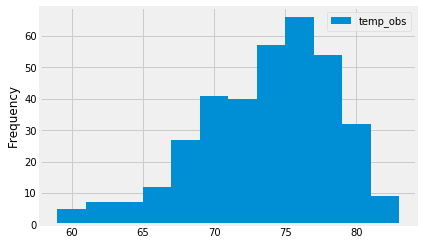

In [11]:
# using `station_id` find most recent 12 months of
#   ... temperature observation data then plot the results as a histogram

# extract boundaries for date/time
end_date = session.query(Measurement.date).\
    filter(Measurement.station == station_id).\
    order_by(desc(Measurement.date)).limit(10).all()[0][0]

begin_date = end_date - dt.timedelta(days=365)

# get relavent data for weather station
results = session.query(Measurement.temp_obs).\
    filter(Measurement.date >= begin_date).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.station == station_id)

station_data = pd.DataFrame(results).astype({'temp_obs':'float'})
station_data.plot(kind='hist', bins=12)


In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.temp_obs), func.avg(Measurement.temp_obs), func.max(Measurement.temp_obs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.5714285714286, 74.0)]
